## SGD Collaborative Filtering



In [5]:
import numpy as np
import seaborn as sns
sns.set_theme()

ModuleNotFoundError: No module named 'numpy'

Generate Movie Rating Data

Given n_movie, n_user, and n_feature,

1. Generate a random user preference matrix of shape: n_feature * n_user
2. Generate a random movie feature matrix of shape: n_feature * n_movie

In [ ]:
# Constants
N_MOVIE = 100
N_USER = 100
N_FEATURE = 10
MAX_RATING = 10

In [ ]:
# Methods to generate movie rating data based on collaborative filtering model.
def generate_user_perference(n_user: int, n_feature: int) -> np.array:
  """Generates a random matrix of user perference.

  Args:
    n_feature: number of features.
    n_user: number of users.

  Returns:
    A random matrix of shape n_user * n_feature  perference coefficients in range
     [0, 1].
  """
  return np.random.random([n_user, n_feature])


def generate_movie_feature(n_movie: int, n_feature: int) -> np.array:
  """Generates a random matrix of movie latent features.

  Args:
    n_feature: number of features.
    n_user: number of movies.

  Returns:
    A random matrix of shape n_movie * n_feature with latent features in range
    [0, 1].
  """
  return np.random.random([n_movie, n_feature])


def compute_movie_rating(user_matrix: np.array, movie_matrix: np.array) -> np.array:
  """Computes the ratings.

  Returns:
    A matrix of rating in shape of n_user * n_movie.
  """
  if len(user_matrix.shape) != 2:
    raise ValueError("User matrix must be 2-dim.")
  if len(movie_matrix.shape) != 2:
    raise ValueError("Movie matrix must be 2-dim.")
  if movie_matrix.shape[1] != user_matrix.shape[1]:
    raise ValueError("User matrix and movie matrix must have the same number of"
    " rows.")
  n_user, n_feature = user_matrix.shape
  n_movie, n_feature = movie_matrix.shape

  rating_matrix = movie_matrix.dot(user_matrix.T)
  max_rating = rating_matrix.max()
  rating_matrix = np.round(rating_matrix / max_rating * MAX_RATING)
  return rating_matrix


<Axes: >

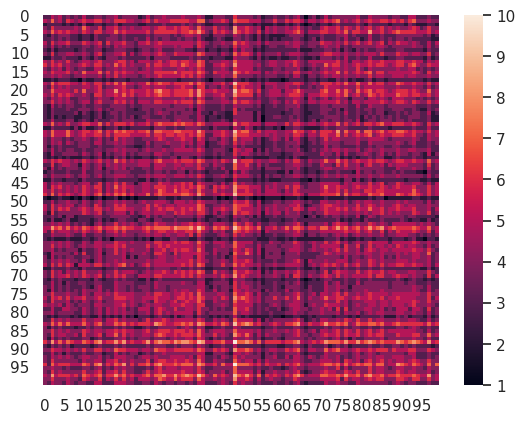

In [ ]:
rating = compute_movie_rating(generate_user_perference(N_USER, N_FEATURE), generate_movie_feature(N_MOVIE, N_FEATURE))
sns.heatmap(rating)

In [ ]:
"""
Created on Sun Jan 19 11:43:40 2020

@author: yajingleo
"""

"""
Stochastic Gradient Descent for Collaborative Filtering Model
"""

import random
from typing import Tuple, List, Dict

import pandas as pd
import numpy as np
from scipy import io


def build_rating_df(rating_matrix: np.array, is_rated_matrix: np.array) -> \
      pd.DataFrame:
    """ Returns a pandas.DataFrame from numpy arrays to serialize data.

    Args:
      rating_matrix: ratings matrix.
      is_rated_matrix: 0/1 rated matrix.

    Returns:
      A data frame with columns ["user_ind", "movie_ind", "rating"] for rated movies.
    """
    if rating_matrix.shape != is_rated_matrix.shape:
      raise ValueError("Two matrices must have the same shape.")
    movie_inds, user_inds, ratings = [], [], []

    m, n = rating_matrix.shape
    for i in range(m):
      for j in range(n):
        if is_rated_matrix[i][j]:
          movie_inds.append(i)
          user_inds.append(j)
          ratings.append(rating_matrix[i][j])

    return pd.DataFrame({"user_ind" : user_inds,
                         "movie_ind" : movie_inds,
                         "rating" : ratings})

def parse_rating(rating_df: pd.DataFrame, n_lines: int = 0) -> \
      Tuple[np.ndarray, np.ndarray] :
    """Parse ratings from DataFrame to numpy array.

    Args:
      rating_df: pandas.DataFrame: rating input with columns
        ["movie_ind", "user_ind", "rating"].
      n_lines: max number of lines to parse

    Returns:
      A tuple of outputs [rating_matrix, has_rated_matrix]:
        rating_matrix: A matrix of ratings: np.ndarray
        has_rated_matrix: A 0/1 matrix of ratings: np.ndarray
    """
    if not set(["movie_ind", "user_ind", "rating"]).issubset(rating_df.columns):
      raise ValueError('rating_df must have columns, "movie_ind", "user_ind"'
      ', "rating"]')
    rating_df = rating_df[["movie_ind", "user_ind", "rating"]]
    if n_lines:
      rating_df = rating_df.head(n_lines)

    unique_movie_inds = sorted(rating_df.movie_ind.unique())
    unique_user_inds = sorted(rating_df.user_ind.unique())
    n_movie = len(unique_movie_inds)
    n_user = len(unique_user_inds)

    # A map from movie_ind to a unique internal index
    movie_inds_map = {unique_movie_inds[i] : i for i in range(n_movie)}
    # A map from user_ind to a unique internal index
    user_inds_map = {unique_user_inds[i] : i for i in range(n_user)}

    # Build matrix
    rating_mat = np.zeros([n_movie, n_user])
    has_rated_mat = np.zeros([n_movie, n_user])

    for movie_ind, user_ind, rating in rating_df.values:
      row_ind = movie_inds_map[movie_ind]
      col_ind = user_inds_map[user_ind]
      rating_mat[row_ind][col_ind] = rating
      has_rated_mat[row_ind][col_ind] = 1

    return rating_mat, has_rated_mat


def point_loss(movie_matrix: np.ndarray, user_matrix: np.ndarray, \
                args: Tuple[np.ndarray, np.ndarray, float, int, int, int, int] \
               ) -> np.ndarray:
    """Computes the error matrix.

    Args:
      movie_matrix: A matrix of latent movie features, in shape
        n_feature * n_movie.
      user_matrix: A matrix of the preference on latent features, in shape
        n_feature * n_user.
      args: A tuple of (rating_matrix, has_rated_matrix, lambda_, n_movie,
        n_user, n_feature, mini_batch)

    Returns:
      The matrix of pointwise square loss.
    """
    if len(args) != 7:
      raise ValueError('Argument "args" must have 7 field')
    rating_matrix, has_rated_matrix, lambda_, n_movie, n_user, n_feature, mini_batch = args

    estimated_matrix = movie_matrix.dot(user_matrix.T)
    error_matrix = (estimated_matrix - rating_matrix) * has_rated_matrix

    return error_matrix * error_matrix


def total_loss(movie_matrix: np.ndarray, user_matrix: np.ndarray, \
                args: Tuple[np.ndarray, np.ndarray, float, int, int, int, int] \
               ) -> float:
    """Computes average square loss.

    Args:
        movie_features: A matrix of latent movie features.
        user_features: A matrix of latent user features.
        args: A tuple of (rating_matrix, has_rated_matrix, lambda_, n_movie, \
                          n_user, n_feature)

    Returns:
        The ordinary square loss.
    """
    if len(args) != 7:
      raise ValueError('Argument "args" must have 7 field')
    rating_matrix, has_rated_matrix, lambda_, n_movie, n_user, n_feature, mini_batch = args

    return point_loss(movie_matrix, user_matrix, args).sum() / has_rated_matrix.sum()


def normalize(matrix: np.ndarray):
    """Normalizes the matrix such that each row has mean 0.

    Args:
        matrix: A matrix.
    """
    m, n = matrix.shape
    for i in range(m):
        mean = matrix[i].mean()
        for j in range(n):
            matrix[i, j] =  float(matrix[i, j]) - mean

def norm_square(matrix: np.ndarray) -> float:
    """Computes the square norm of a matrix.
    """
    return np.linalg.norm(matrix)**2


def update_gradient(movie_matrix: np.ndarray, user_matrix: np.ndarray, \
                    rating_df: pd.DataFrame, \
                    eta: float, args: List):
    """ Update movie and user features in online training.

    Args:
      movie_matrix: movie feature matrix
      user_matrix: user feature matrix
      rating_df: A row containing [movie_ind, user_ind, rating]
      eta: learning rate
      args: [rating_matrix, has_rated_matrix, lambda_, n_movie, n_user, \
        n_feature, mini_batch]
    """
    if len(args) != 7:
      raise ValueError('Argument "args" must have 7 field')
    rating_matrix, has_rated_matrix, lambda_, n_movie, n_user, n_feature, mini_batch = args

    movie_inds = rating_df.movie_ind.values
    user_inds = rating_df.user_ind.values
    ratings = rating_df.rating.values

    grad_movie = np.zeros(n_feature)
    grad_user = np.zeros(n_feature)

    # Dynamically update the rating matrix and has rated 0/1 matrix
    for i in range(len(ratings)):
      movie_ind, user_ind, rating = movie_inds[i], user_inds[i], ratings[i]

      ind_m = int(movie_ind)
      ind_u = int(user_ind)

      # Update the matrix
      rating_matrix[ind_m][ind_u] = rating
      has_rated_matrix[ind_m][ind_u] = 1

      movie_m = movie_matrix[ind_m].copy()
      user_u = user_matrix[ind_u].copy()

      # Compute gradients
      grad_movie += (user_u.dot(movie_m) - rating) * user_u + lambda_ * movie_m
      grad_user += (user_u.dot(movie_m) - rating) * movie_m + lambda_ * user_u

      # Error(M, U) = Tr((M * U - R).T * (M * U - R)) + 1/2 *|M|^2 + 1/2 * |U|^2
      # Nambla(Error)_M = U.T * (M * U - R)

      # Update parameters
      movie_matrix[ind_m] = movie_m - grad_movie * eta / mini_batch
      user_matrix[ind_u] = user_u - grad_user * eta / mini_batch


def sgd(movie_matrix: np.ndarray, user_matrix: np.ndarray, \
        rating_df: pd.DataFrame, eta: float, args: Tuple, n_epoch: int = 0) -> \
        pd.DataFrame:
    """Updates gradient using mini-batch stochastic gradient descent.

    Args:
        X: movie feature matrix
        Theta: user feature matrix
        rating_df: A dataframe of ratings
        eta: learning rate
        args: [ratings, has_ratings, lambda_, n_movie, n_user, n_feature]
        n_epoch: The number of epochs. If zero, the code will automatically
          compute a value.

    Returns:
        Training loss dataframe
    """
    rating_matrix, has_rated_matrix, lambda_, n_movie, n_user, n_feature, mini_batch = args

    n_rating = rating_df.shape[0]
    indices = list(range(n_rating))
    random.shuffle(indices)

    training_loss = pd.DataFrame()
    n_epoch = n_epoch if n_epoch else len(indices) // mini_batch
    for i in range(n_epoch):
        row_start = (i * mini_batch) % n_rating
        row_end = ((i+1) * mini_batch) % n_rating
        mini_batch_rating_df = rating_df.iloc[ row_start : row_end ]
        update_gradient(movie_matrix, user_matrix, mini_batch_rating_df, eta, \
                        args)
        if i % 10 == 0:
            mini_batch_training_loss = pd.DataFrame( \
             {"epoch": [i],
              "loss": [total_loss(movie_matrix, user_matrix, args)]})
            training_loss = pd.concat(
                [training_loss, mini_batch_training_loss],
                ignore_index=True)

    return training_loss


def training(rating_df: pd.DataFrame,
             n_feature: int,
             mini_batch : int = 100,
             eta : float = 0.1,
             lambda_ : float = 0,
             n_epoch: int = 0):
    """Trains the model using SGD.

    Args:
        rating_df: Dataframe of ratings.
        n_feature: Number of features.
        mini_batch: Size of the training data in each batch.
        eta: Learning rate.
        lambda_: Coefficient of regularization.
        n_epoch: Number of training batches.
    """
    n_movie = len(set(rating_df.movie_ind))
    n_user = len(set(rating_df.user_ind))

    rating_matrix, has_rated_matrix = parse_rating(rating_df)

    args = (rating_matrix, has_rated_matrix, lambda_, n_movie, n_user, n_feature, mini_batch)

    movie_matrix = np.random.rand(n_movie, n_feature)
    user_matrix = np.random.rand(n_user, n_feature)


    training_loss = sgd(movie_matrix, user_matrix, rating_df, eta, args, n_epoch)

    return (movie_matrix, user_matrix, training_loss)

In [ ]:
print("Generating the rating data.")
movie_matrix = generate_movie_feature(N_MOVIE, N_FEATURE)
user_matrix = generate_user_perference(N_USER, N_FEATURE)
rating_matrix = compute_movie_rating(user_matrix, movie_matrix)
has_rated_matrix = np.round(np.random.random([N_MOVIE, N_USER]))
print("Finished.\n")
rating_df = build_rating_df(rating_matrix, has_rated_matrix)
print("rating_df: \n", rating_df)

Generating the rating data.
Finished.

rating_df: 
       user_ind  movie_ind  rating
0            3          0     6.0
1            5          0     5.0
2            7          0     7.0
3            8          0     6.0
4           11          0     6.0
...        ...        ...     ...
4995        90         99     2.0
4996        91         99     4.0
4997        93         99     3.0
4998        96         99     5.0
4999        99         99     4.0

[5000 rows x 3 columns]


In [ ]:
fitted_movie_matrix, fitted_user_matrix, training_loss =\
    training(rating_df,
             N_FEATURE,
             mini_batch = 1,
             eta = 0.1,
             lambda_ = 0,
             n_epoch = 10000)

fitted_rating_matrix =  np.round(fitted_movie_matrix.dot(fitted_user_matrix.T))

<Axes: xlabel='epoch', ylabel='loss'>

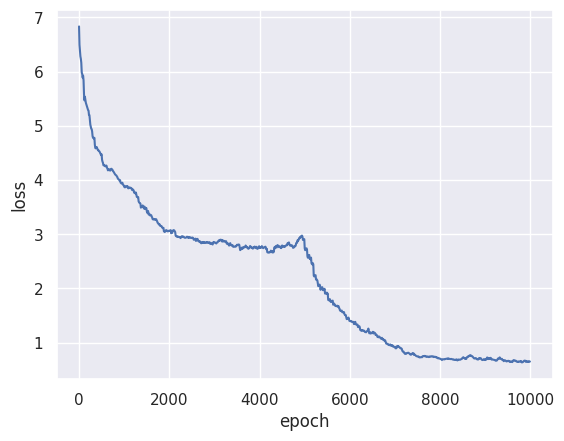

In [ ]:
sns.lineplot(x = "epoch", y = "loss", data = training_loss)

In [ ]:
rating_matrix

array([[6., 4., 7., ..., 6., 8., 7.],
       [5., 2., 6., ..., 6., 7., 6.],
       [6., 4., 7., ..., 6., 8., 6.],
       ...,
       [3., 2., 5., ..., 4., 5., 5.],
       [4., 2., 5., ..., 4., 4., 3.],
       [4., 3., 4., ..., 4., 5., 4.]])

In [ ]:
fitted_rating_matrix

array([[5., 4., 8., ..., 6., 8., 6.],
       [4., 3., 5., ..., 5., 6., 6.],
       [5., 4., 9., ..., 5., 7., 7.],
       ...,
       [4., 3., 6., ..., 4., 6., 5.],
       [3., 2., 5., ..., 4., 4., 3.],
       [3., 2., 4., ..., 4., 5., 4.]])

In [ ]:
rating_matrix - fitted_rating_matrix

array([[ 1.,  0., -1., ...,  0.,  0.,  1.],
       [ 1., -1.,  1., ...,  1.,  1.,  0.],
       [ 1.,  0., -2., ...,  1.,  1., -1.],
       ...,
       [-1., -1., -1., ...,  0., -1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.]])

In [ ]:
# Print the fitting error on ratings
(norm_square((fitted_rating_matrix - rating_matrix)*has_rated_matrix)/fitted_rating_matrix.size)**0.5

np.float64(0.6043177971895252)

In [ ]:
# Print the fitting error on movie features
(norm_square((fitted_movie_matrix - movie_matrix))/movie_matrix.size)**0.5

np.float64(0.452801010147332)

<Axes: >

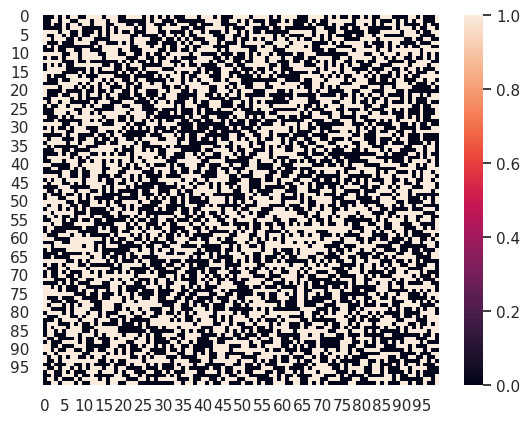

In [ ]:
sns.heatmap(has_rated_matrix)

<Axes: >

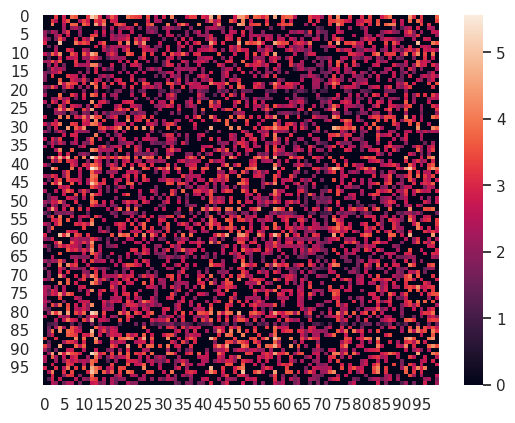

In [ ]:
sns.heatmap(movie_matrix.dot(user_matrix.T) * has_rated_matrix)

# Fit the learning curve: training loss = O(n^-K)

We take the log transformations of the learning and fit the exponential.

In [ ]:
training_loss["log_loss"] = np.log(training_loss.loss)
training_loss["log_epoch"] = np.log(training_loss.epoch)
training_loss.drop(0, inplace = True)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='log_epoch', ylabel='log_loss'>

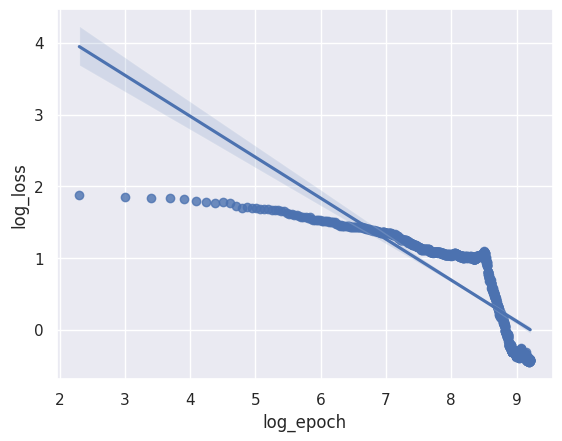

In [ ]:
sns.regplot(x = "log_epoch", y = "log_loss", data = training_loss)

In [ ]:
# Fit a linear regression between the log loss and epoch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(training_loss[["log_epoch"]], training_loss.log_loss)

model.coef_

array([-0.57164009])

## Make the simulation of Multi-Arm Bandit Using ML-UCB

We need to design a simulation of Multi-Arm Bandit Using ML-UCB
1. Every time a user is coming, we compute the embedding of the user and all the movie embedding.
1. Then, we compute the ML-UCB arm, and recommend the user.
1. Get the rating of the movie.
1. Repeat.

In [ ]:
class UCBRecommendation:

  def __init__(self):
    self.users = []
    self.movies = []
    self.ratings = pd.DataFrame(columns = ["user_ind", "movie_ind", "rating"])
    self.


In [ ]:
l

NameError: name 'l' is not defined